# Simulation-based Calibration in SBI

After a posterior has been trained given a simulation, predictions from this posterior should be made subject to several diagnostical tests. [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) are one such way to "critique" a trained model. Another important approach to such diagnostics is simulation-based calibration as reported by [Talts et al, 2018](https://arxiv.org/abs/1804.06788).

**Simulation-based calibration** (SBC) boils down to a visual (qualitative) way as well as a quantitive measure to check, if the uncertainties obtained from the ensemble of posterior samples meets expectations. In this way, SBC can unveil if the uncertainties of the posterior samples can be considered well calibrated (or healthy if you will). SBC can be used to uncover malignant posteriors. SBC cannot be used to fix this posterior. As such, SBC can be viewed as a necessary condition for a valid inference using a posterior.

## in a nutshell

SBC repeats posterior inference to obtain predicted samples of $x_{true}$ (obtained from $simulator(\theta_{true})$). SBC then ranks these $\theta_{pp}$ with respect to $\theta_{true}$. This rank is calculated by counting those samples $\theta_{pp}$ which fall below $\theta_{true}$. 

### key ideas behind SBC

The core idea behind SBC is two fold: 

- SBC ranks of posterior samples with respect to their ground truth follow a uniform distribution.  
(If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

- samples from the data averaged posterior are distributed according to the prior

### What can SBC diagnose?

**SBC can inform us whether we are not wrong.** However, it cannot tell us whether we are right. SBC checks a necessary condition. For example, imagine you run SBC using the prior as a posterior. The ranks would be perfectly uniform. But the inference would be wrong.

**The [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) can be seen as the complementary sufficient check** for the posterior (only as a methaphor, no theoretical guarantees here). Using the prior as a posterior and then doing predictive checks would clearly show that inference failed. 

So SBC can ...

- tell us whether a method produces posterior samples $\theta_{pp}$ that have a systematic negative or positive bias (shift in the mean of the predictions)
- tell us whether a method produces posterior samples $\theta_{pp}$ that are systematically over- or underdispersed (too large or too small variance) 

## a healthy posterior

Let's take the gaussian linear simulation and run inference with (S)NPE on it. As we do not perform any rounds, we actually only do neural posterior estimation (NPE).

In [1]:
import torch
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc, run_sbc, get_nltp
from sbi.inference import SNPE_C, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

In [15]:
num_dim = 3
num_simulations = 10_000

ref_likelihood_shift = zeros(num_dim)
ref_likelihood_cov = eye(num_dim)*1e-4

prior_mean = zeros(num_dim)
prior_cov = eye(num_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)




In [16]:
def simulator(theta):
    return linear_gaussian(theta,
                           ref_likelihood_shift,
                           ref_likelihood_cov)
theta, x = simulate_for_sbi(simulator, prior, num_simulations)


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
# we define a hold-out sample of 1 to build an observation
theta_o = prior.sample((1,))
x_o = simulator(theta_o)

In [18]:
inferer = SNPE_C(prior, show_progress_bars=False, density_estimator="mdn")
_ = inferer.append_simulations(theta, x).train(
        training_batch_size=128, max_num_epochs=50
    )

In [19]:
posterior = inferer.build_posterior().set_default_x(x_o)
posterior_samples = posterior.sample((1_000,))

print(posterior_samples.mean(dim=0),theta_o)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([-0.0979, -0.0605, -0.9819]) tensor([[-0.1002, -0.0519, -0.9920]])


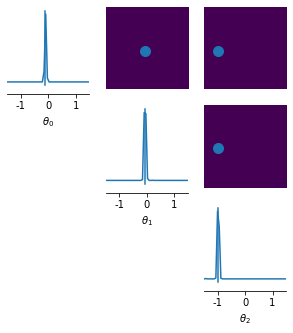

In [22]:
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_samples,
    points=theta_o,
    limits=torch.tensor([[-1.5, 1.5]]*3),
    upper=['kde'],
    diag=['kde'],
    figsize=(5,5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

We have a working and trained posterior at this point which can be considered perfect. Judging from the pairplot above, everything is normal if not ideal.
Let's look at the SBC metrics in a case, where all predictions should be healthy.

In [23]:
num_sbc_runs = 1000
thetas = prior.sample((num_sbc_runs,))
xs = simulator(thetas)

In [24]:
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_workers=4)

Running 1000 sbc runs in 1000
                    batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)

In [26]:
print(check_stats)

{'ks_pvals': tensor([0.0000e+00, 0.0000e+00, 4.7159e-41]), 'c2st_ranks': tensor([0.6505, 0.6965, 0.6535]), 'c2st_dap': tensor([0.4530, 0.4960, 0.4855])}


In [27]:
from sbi.analysis.plot import sbc_rank_plot


torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


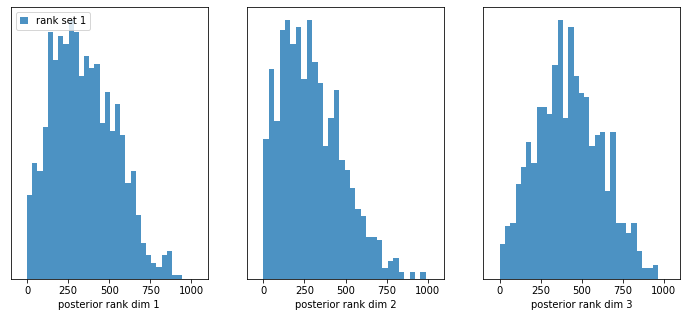

In [28]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)